In [32]:
import os
import onnx
import torch
import torchvision

import numpy as np
import pandas as pd
import onnxruntime as ort
# import onnxruntime.ope
import matplotlib.pyplot as plt


In [33]:
torch.__version__, torchvision.__version__, torch.cuda_version

('1.9.0', '0.10.0', '11.1')

In [34]:
ort.__version__, ort.capi.version_info.cuda_version, ort.capi.version_info.cudnn_version

('1.8.1', '11.0', '8')

In [35]:
ort.get_available_providers()

['CUDAExecutionProvider', 'CPUExecutionProvider']

In [36]:
# session.set_providers(['OpenVINOExecutionProvider'])
onnx_file='../models/alexnet.onnx'
session = ort.InferenceSession(onnx_file, providers=['OpenVINOExecutionProvider'])

C:\Users\rosul\anaconda3\envs\pytorch\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:53: UserWarning: Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'CUDAExecutionProvider, CPUExecutionProvider'
  warnings.warn("Specified provider '{}' is not in available provider names."


In [37]:
# ort.

In [38]:
ort.get_all_providers()

['TensorrtExecutionProvider',
 'CUDAExecutionProvider',
 'MIGraphXExecutionProvider',
 'ROCMExecutionProvider',
 'OpenVINOExecutionProvider',
 'DnnlExecutionProvider',
 'NupharExecutionProvider',
 'VitisAIExecutionProvider',
 'NnapiExecutionProvider',
 'ArmNNExecutionProvider',
 'ACLExecutionProvider',
 'DmlExecutionProvider',
 'RknpuExecutionProvider',
 'CPUExecutionProvider']

## Load results

Hardware:
- CPU: i7-10875H
- GPU: NVIDIA GeForce RTX 2070
- RAM: 32GB

Results where obtained by running:
```
python benchmark.py -f pytorch -m all -b 6 -d cpu cuda -e -v
python benchmark.py -f onnx -m all -b 6 -d cpu cuda -e -v
```

In [39]:
results_dir = '../results'
results = [f'{results_dir}/{f}' for f in os.listdir(results_dir)]
results

['../results/onnx.csv', '../results/pytorch.csv', '../results/script.csv']

In [40]:
dfs = [pd.read_csv(f) for f in results]

df = pd.concat(dfs, ignore_index=True)

## Analysis

In [41]:
df

,model,device,bs,time,engine,size
0,alexnet,cpu,1,10.000944,onnx,224
1,alexnet,cpu,2,7.499695,onnx,224
2,alexnet,cpu,4,4.749656,onnx,224
3,alexnet,cpu,8,3.250241,onnx,224
4,alexnet,cpu,16,4.999936,onnx,224
...,...,...,...,...,...,...
445,mnasnet0_5,cuda,1,7.999182,script,224
446,mnasnet0_5,cuda,2,4.501104,script,224
447,mnasnet0_5,cuda,4,2.499342,script,224
448,mnasnet0_5,cuda,8,1.000136,script,224


## Plot results

In [42]:
df.model.nunique(), df.model.unique().tolist()

(15,
 ['alexnet',
  'resnet18',
  'resnet50',
  'vgg16',
  'vgg19',
  'squeezenet1_1',
  'densenet121',
  'inception_v3',
  'googlenet',
  'mobilenet_v2',
  'mobilenet_v3_large',
  'mobilenet_v3_small',
  'resnext50_32x4d',
  'wide_resnet50_2',
  'mnasnet0_5'])

In [43]:
engines, architectures, len(architectures)

(array(['onnx', 'pytorch'], dtype=object),
 array(['alexnet', 'resnet18', 'resnet50', 'vgg16', 'vgg19',
        'squeezenet1_1', 'densenet121', 'inception_v3', 'googlenet',
        'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small',
        'resnext50_32x4d', 'wide_resnet50_2', 'mnasnet0_5'], dtype=object),
 15)

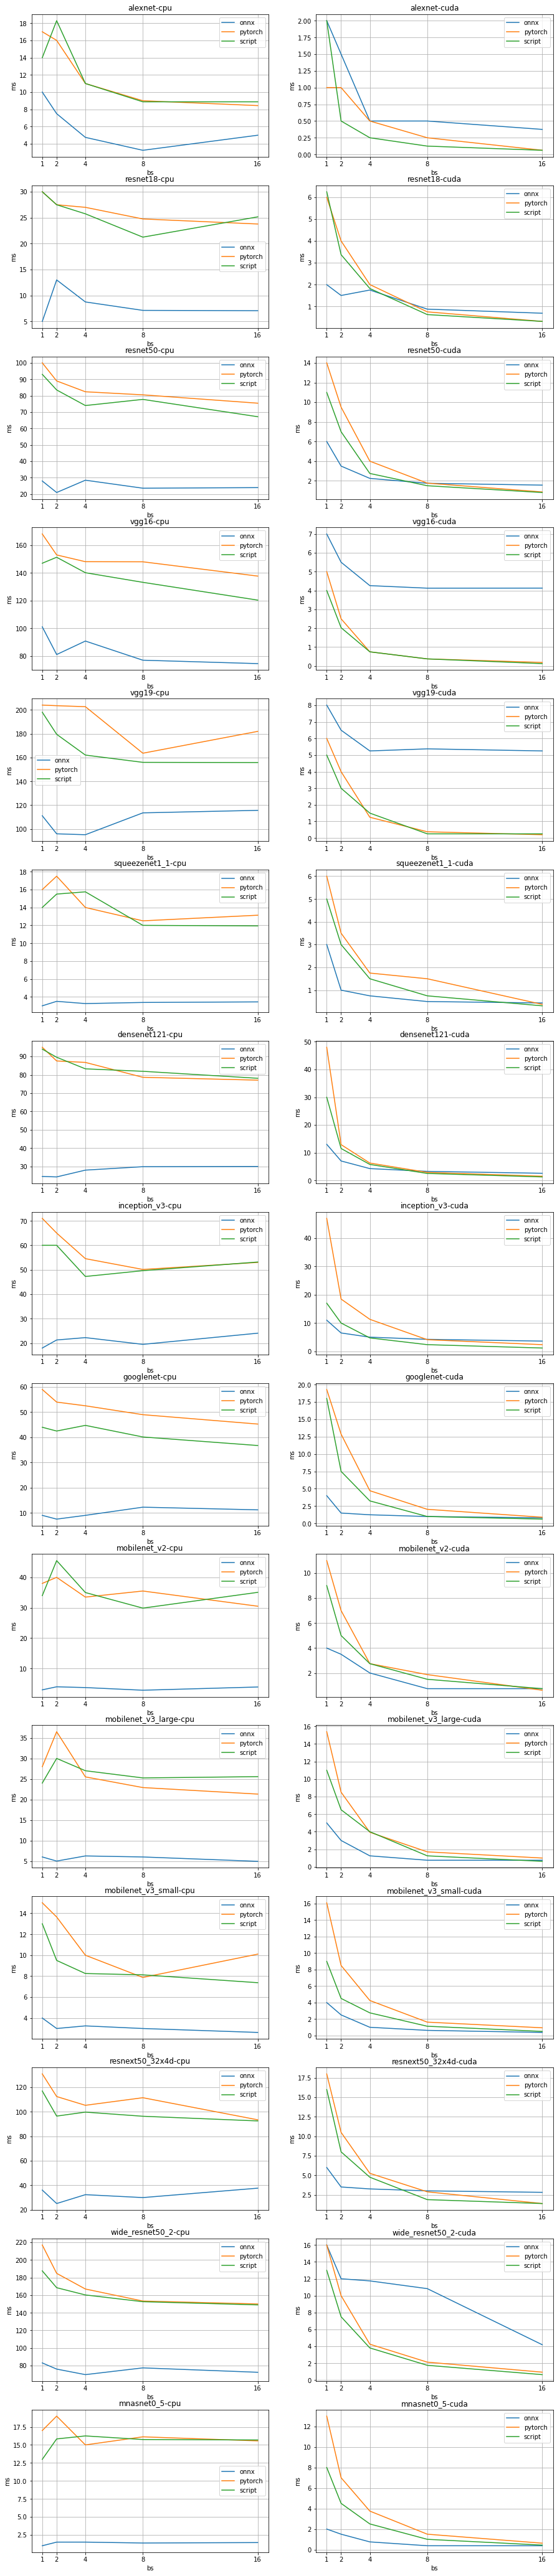

In [44]:
# def plot_results(df, device):
architectures = df.model.unique()
engines = df.engine.unique()

count = len(architectures)

bs = int(np.log2(df.bs.max()))
bs = [2**i for i in range(bs+1)]

# fig, axs = plt.subplots(count, len(engines), figsize=(15,75))
fig, axs = plt.subplots(count, 2, figsize=(15,75))
axs = axs.flatten()

for i, arch in enumerate(architectures):
    idx = i*2
    
    results = df[df.model == arch]
    
    for e in engines:
        axs[idx].plot(bs, results[(results.device == 'cpu') & (results.engine == e)].time.tolist(), label=e)
#         print(results[(results.device == 'cuda') & (results.engine == e)].time.tolist())
        axs[idx+1].plot(bs, results[(results.device == 'cuda') & (results.engine == e)].time.tolist(), label=e)

    for j, dev in enumerate(['cpu', 'cuda']):
        axs[idx+j].set_xticks(bs)
        axs[idx+j].grid()
        axs[idx+j].legend()
        axs[idx+j].set_title(f'{arch}-{dev}')
        axs[idx+j].set_ylabel('ms')
        axs[idx+j].set_xlabel('bs')

plt.show()